In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import joblib

import tensorflow as tf
import re
import random
import tf_keras
from tf_keras.callbacks import EarlyStopping  # Use tf.keras.callbacks
import kagglehub
import zipfile
from transformers import TFAutoModel
import shutil

## Downloading the data

In [2]:
def download_and_extract_data(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/hourly-breakout-data-no-false-breakout-category")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data(filename="output_latest.zip", filename_output="output")

100%|██████████| 241M/241M [00:12<00:00, 19.6MB/s]

Extracting files...


Renamed downloaded file to 'output_latest.zip'


## Getting the data ready for the machine learning model

In [3]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Directories
original_train_dir = '/content/output_latest.zip/output_hourly_breakout_no_false/output_hourly_price_action_patterns_training_and_validation/train'
original_valid_dir = '/content/output_latest.zip/output_hourly_breakout_no_false/output_hourly_price_action_patterns_training_and_validation/validation'
original_test_dir = '/content/output_latest.zip/output_hourly_breakout_no_false/output_hourly_price_action_patterns_testing/test'

# Create balanced train dataset
train_ds = tf_keras.utils.image_dataset_from_directory(
    directory=original_train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

# Create balanced valid dataset
valid_ds = tf_keras.utils.image_dataset_from_directory(
    directory=original_valid_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

# Create balanced test dataset
test_ds = tf_keras.utils.image_dataset_from_directory(
    directory=original_test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

class_names = train_ds.class_names
print("Balanced datasets created successfully!")

Found 17782 files belonging to 3 classes.
Found 4367 files belonging to 3 classes.
Found 22141 files belonging to 3 classes.
Balanced datasets created successfully!


In [4]:
AUTOTUNE = tf.data.AUTOTUNE # let TensorFlow find the best values to use automatically

# Shuffle and optimize performance on training datasets
# Note: these methods can be chained together and will have the same effect as calling them individually
train_ds = train_ds.cache().shuffle(buffer_size=100*BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Don't need to shuffle valid datasets (for easier evaluation)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Don't need to shuffle test datasets (for easier evaluation)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Building the machine learning model

In [5]:
def count_parameters(model, print_output=True):
  """
  Counts the number of trainable, non-trainable and total parameters of a given model.
  """
  trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_weights])
  non_trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.non_trainable_weights])
  total_parameters = trainable_parameters + non_trainable_parameters
  if print_output:
    print(f"Model {model.name} parameter counts:")
    print(f"Total parameters: {total_parameters}")
    print(f"Trainable parameters: {trainable_parameters}")
    print(f"Non-trainable parameters: {non_trainable_parameters}")
  else:
    return total_parameters, trainable_parameters, non_trainable_parameters

In [6]:
def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: tuple[int, int, int] = (224, 224, 3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,
                 activation: str = "softmax",
                 base_model: tf_keras.Model = None,
                 model_name: str = "model") -> tf_keras.Model:
  """
  Create an EfficientNetV2 B0 feature extractor model with a custom classifier layer.

  Args:
      include_top (bool, optional): Whether to include the top (classifier) layers of the model.
      num_classes (int, optional): Number of output classes for the classifier layer.
      input_shape (tuple[int, int, int], optional): Input shape for the model's images (height, width, channels).
      include_preprocessing (bool, optional): Whether to include preprocessing layers for image normalization.
      trainable (bool, optional): Whether to make the base model trainable.
      dropout (float, optional): Dropout rate for the global average pooling layer.
      activation (str, optional): Activation function for the output layer.
      model_name (str, optional): Name for the created model.

  Returns:
      tf.keras.Model: A TensorFlow Keras model with the specified configuration.
  """
  if base_model is None:
    print('Base Model is None please enter the based model')
    return None

  if activation == "softmax":
    activation = tf_keras.activations.softmax
  elif activation == "sigmoid":
    activation = tf_keras.activations.sigmoid

  # Freeze the base model (if necessary)
  base_model.trainable = trainable

  # Create input layer
  inputs = tf_keras.Input(shape=input_shape, name="input_layer")

  # Create model backbone (middle/hidden layers)
  x = base_model(inputs, training=trainable)

  # Create output layer (also known as "classifier" layer)
  outputs = tf_keras.layers.Dense(
      units=num_classes,
      activation=activation,
      name="output_layer"
  )(x)

  # Connect input and output layer
  model = tf_keras.Model(inputs=inputs, outputs=outputs, name=model_name)

  return model

In [7]:
from transformers import TFAutoModel
import tensorflow as tf

def create_model_transformers(model_name: str,
                              num_classes: int = 1000,
                              input_shape: tuple = (224, 224, 3),
                              trainable: bool = False,
                              dropout: float = 0.2,
                              activation: str = "softmax") -> tf.keras.Model:
    """
    Create a Transformer or ConvNeXt model with a custom classifier layer.

    Args:
        model_name (str): Hugging Face model name (e.g., "facebook/convnext-xlarge-224-22k-1k").
        num_classes (int): Number of output classes for the classifier layer.
        input_shape (tuple): Input shape for the model's images (height, width, channels).
        trainable (bool): Whether to make the base model trainable.
        dropout (float): Dropout rate for the classifier.
        activation (str): Activation function for the classifier ("softmax" or "sigmoid").

    Returns:
        tf.keras.Model: A TensorFlow model with the specified configuration.
    """
    # Load the pre-trained Hugging Face model
    base_model = TFAutoModel.from_pretrained(model_name)

    # Freeze the base model layers if not trainable
    base_model.trainable = trainable

    # Define input layer
    inputs = tf_keras.Input(shape=input_shape, name="input_layer")

    # Transpose inputs if required for channels-first models
    transposed_inputs = tf_keras.layers.Permute((3, 1, 2))(inputs)

    # Pass inputs through the base model
    base_outputs = base_model(transposed_inputs)

    # Handle pooling automatically based on output shape
    base_output_shape = base_outputs.last_hidden_state.shape.rank  # Detect number of dimensions

    if base_output_shape == 3:
        # If output is 3D (e.g., Transformers), use GlobalAveragePooling1D
        pooled_outputs = tf_keras.layers.GlobalAveragePooling1D()(base_outputs.last_hidden_state)
    elif base_output_shape == 4:
        # If output is 4D (e.g., ConvNeXt), use GlobalAveragePooling2D
        pooled_outputs = tf_keras.layers.GlobalAveragePooling2D()(base_outputs.last_hidden_state)
    else:
        raise ValueError(f"Unsupported output shape rank: {base_output_shape}")

    # Apply dropout for regularization
    if dropout > 0:
        pooled_outputs = tf_keras.layers.Dropout(dropout)(pooled_outputs)

    # Add custom classification layer
    outputs = tf_keras.layers.Dense(
        units=num_classes,
        activation=activation,
        name="output_layer"
    )(pooled_outputs)

    # Build and return the final model
    model = tf_keras.Model(inputs=inputs, outputs=outputs, name=f"{model_name}_classifier")

    return model


In [8]:
def plot_model_loss_curves(history: tf.keras.callbacks.History) -> None:
  """Takes a History object and plots loss and accuracy curves."""

  # Get the accuracy values
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  # Get the loss values
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  # Get the number of epochs
  epochs_range = range(len(acc))

  # Create accuracy curves plot
  plt.figure(figsize=(14, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label="Training Accuracy")
  plt.plot(epochs_range, val_acc, label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")

  # Create loss curves plot
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label="Training Loss")
  plt.plot(epochs_range, val_loss, label="Validation Loss")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.show()

## Training model - Model_0

In [9]:
# 1. Create a model

# Parameters
include_top = False
input_shape = (224, 224, 3)
include_preprocessing = True

# Create base model
base_model = tf_keras.applications.ConvNeXtXLarge(
    include_top=include_top,
    weights="imagenet",
    input_shape=input_shape,
    include_preprocessing=include_preprocessing,
    pooling="max"  # Can use this instead of adding tf.keras.layers.MaxPooling2D() to the model
)

# Example: Using ViT-Large/16 with ImageNet weights
#model_name = "facebook/convnext-xlarge-224-22k-1k"

# Create the model
#model_0 = create_model_transformers(
    #model_name=model_name,
    #num_classes=len(class_names),
    #input_shape=input_shape,
    #trainable=False,  # Freeze pre-trained layers
    #dropout=0.3,
    #activation="softmax"
#)

model_0 = create_model(num_classes=len(class_names), trainable=True, base_model=base_model)

count_parameters(model=model_0, print_output=True)

# 2. Compile the model
model_0.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001),
                loss=tf_keras.losses.CategoricalCrossentropy(from_logits=False),  # use from_logits=False if using an activation function in final layer
                metrics=["accuracy"])

# Define the EarlyStopping callback
early_stopping = tf_keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor for early stopping
    patience=5,              # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# 3. Fit the model
epochs = 1000
history_0 = model_0.fit(
    x=train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[early_stopping]
)

# Save the weights as a .keras file
weights_save_path = "model_0_weights_fine_tuened.keras"

# Save only the weights
model_0.save_weights(weights_save_path, save_format="h5")
print(f"Weights saved to {weights_save_path}")

1393257616/1393257616 [==============================] - 64s 0us/step
Model model parameter counts:
Total parameters: 348154115.0
Trainable parameters: 348154115
Non-trainable parameters: 0.0
Epoch 1/1000
556/556 [==============================] - 391s 585ms/step - loss: 0.1666 - accuracy: 0.9402 - val_loss: 0.0990 - val_accuracy: 0.9606
Epoch 2/1000
556/556 [==============================] - 309s 557ms/step - loss: 0.0965 - accuracy: 0.9560 - val_loss: 0.0956 - val_accuracy: 0.9574
Epoch 3/1000
556/556 [==============================] - 310s 558ms/step - loss: 0.1014 - accuracy: 0.9553 - val_loss: 0.0822 - val_accuracy: 0.9624
Epoch 4/1000
556/556 [==============================] - 310s 558ms/step - loss: 0.0794 - accuracy: 0.9661 - val_loss: 0.0741 - val_accuracy: 0.9647
Epoch 5/1000
556/556 [==============================] - 309s 557ms/step - loss: 0.0730 - accuracy: 0.9671 - val_loss: 0.0824 - val_accuracy: 0.9620
Epoch 6/1000
556/556 [==============================] - 309s 557ms/s

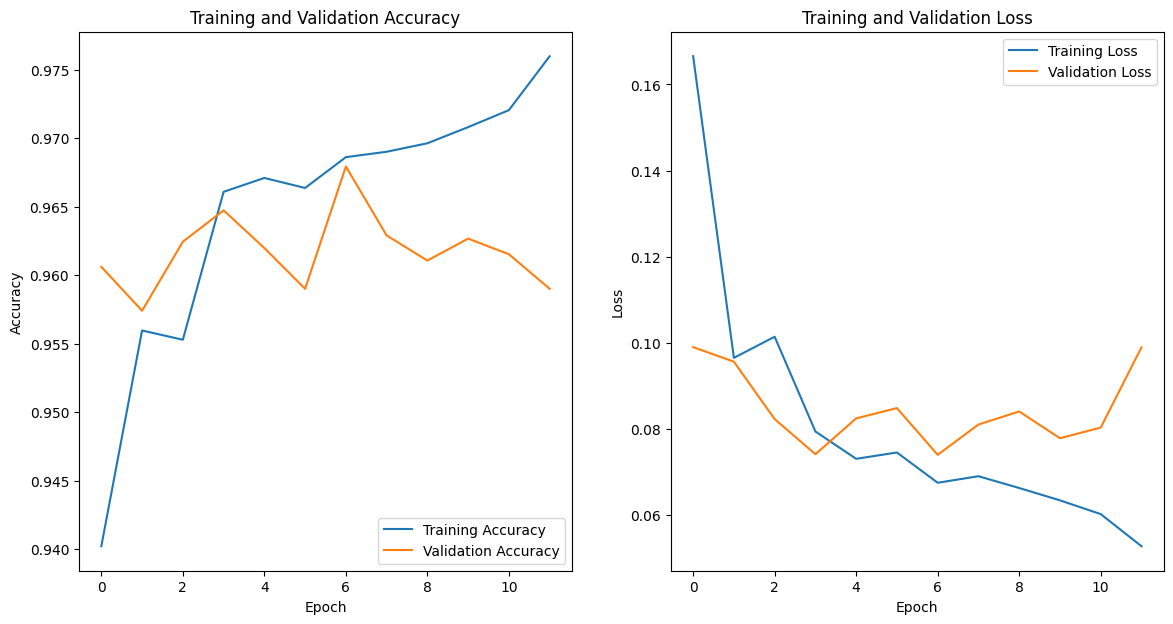

In [10]:
plot_model_loss_curves(history=history_0)

In [11]:
model_0_results = model_0.evaluate(x=test_ds)
model_0_results

692/692 [==============================] - 114s 164ms/step - loss: 0.0694 - accuracy: 0.9687


[0.06940538436174393, 0.9687005877494812]